In [1]:
from wae import *
from torch.distributions import Categorical, Normal, MixtureSameFamily
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import imageio.v2 as imageio  # v2 API

In [2]:
data_path = "/n/fs/ragr-data/users/yihangs/Celegan/structuredVAE/codes/vampprior-mixture-model-test/origin/VampPrior-Mixture-Model/data/simulation/1d-nb/data1/"
X = np.load(data_path + "X.npy")
y = np.load(data_path + "Y.npy")
Z_true = np.load(data_path + "Z.npy")
true_centers = np.load(data_path + "centers.npy")
n_clusters = len(true_centers)

X = torch.from_numpy(X).float()

In [3]:
### define prior

mix_probs = torch.tensor([0.25, 0.25, 0.25, 0.25])

# component means and stds (K,)
means = torch.from_numpy(true_centers.reshape(-1)).float()
#means = torch.tensor([-20.0, -10.0, 0.0, 10.0])
stds  = torch.tensor([0.2, 0.2, 0.2, 0.2])

# define distributions
mix = Categorical(mix_probs)
comp = Normal(means, stds)               # batch of K Normals
gmm = MixtureSameFamily(mix, comp)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = WAE1D(
    prior = gmm,
    in_dim=100, x_dim=100, h_dim=64,
    n_layers_enc=2, n_layers_dec=2,
    embedding_dim=1, 
    likelihood="nb"
).to(device)

In [5]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

dl = DataLoader(TensorDataset(X.float()), batch_size=128, shuffle=True)

In [6]:
epochs = 1000
num_train_data = len(dl)

frames = []
for ep in range(1, epochs + 1):
    print(f"epoch: {ep*1}/{epochs}")
    model.train()
    m_gather = {}
    idx = 0
    for (xb,) in dl:
        idx+=1
        xb = xb.to(device).float()
        #xb_log1p = torch.log1p(xb)

        # update 
        optimizer.zero_grad()
        loss, metrics = model(xb,weight = 10)
        loss.backward()
        optimizer.step()

        # gather metrics
        #print("temperature", temp, step)
        for k,v in metrics.items():
            m_gather[k] = m_gather.get(k, 0.) + metrics[k]

    for k,v in m_gather.items():
        m_gather[k] /= num_train_data

    print(f'train (average) : {m_gather}')
    if ep%1 ==0 and ep<50:
        model.eval()
        with torch.no_grad():
            X_log1p = torch.log1p(X)
            latent_params = model.encoder(X_log1p.to(device))
            enc_mu = latent_params.detach().cpu().numpy()
        fig, ax = plt.subplots(figsize=(6, 4))
        for i in range(n_clusters):
            mask = y == i
            ax.hist(enc_mu[mask, 0], bins=30, alpha=0.6, label=f'True Cluster {i}', density=True)
        ax.set_xlabel('Encoded Latent Value')
        ax.set_ylabel('Density')
        ax.set_title('Encoded Latent Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
        #plt.show()
        #plt.close()
        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        #frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        #frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frame = buf.reshape(h, w, 4)[..., :3]   # drop alpha → RGB
        frames.append(frame)
        plt.close(fig)

epoch: 1/1000
train (average) : {'recon_loss': tensor(2313.4285, device='cuda:0'), 'wasserstein_distance': tensor(0.4961, device='cuda:0'), 'loss': tensor(2318.3899, device='cuda:0')}
epoch: 2/1000
train (average) : {'recon_loss': tensor(2265.8950, device='cuda:0'), 'wasserstein_distance': tensor(0.0944, device='cuda:0'), 'loss': tensor(2266.8386, device='cuda:0')}
epoch: 3/1000
train (average) : {'recon_loss': tensor(2225.1536, device='cuda:0'), 'wasserstein_distance': tensor(0.0999, device='cuda:0'), 'loss': tensor(2226.1526, device='cuda:0')}
epoch: 4/1000
train (average) : {'recon_loss': tensor(2201.0630, device='cuda:0'), 'wasserstein_distance': tensor(0.1030, device='cuda:0'), 'loss': tensor(2202.0930, device='cuda:0')}
epoch: 5/1000
train (average) : {'recon_loss': tensor(2128.4758, device='cuda:0'), 'wasserstein_distance': tensor(0.0825, device='cuda:0'), 'loss': tensor(2129.3008, device='cuda:0')}
epoch: 6/1000
train (average) : {'recon_loss': tensor(2099.6853, device='cuda:0'

In [7]:
model.eval()
with torch.no_grad():
    X_log1p = torch.log1p(X)
    latent_params = model.encoder(X_log1p.to(device))
    enc_mu = latent_params.detach().cpu().numpy()

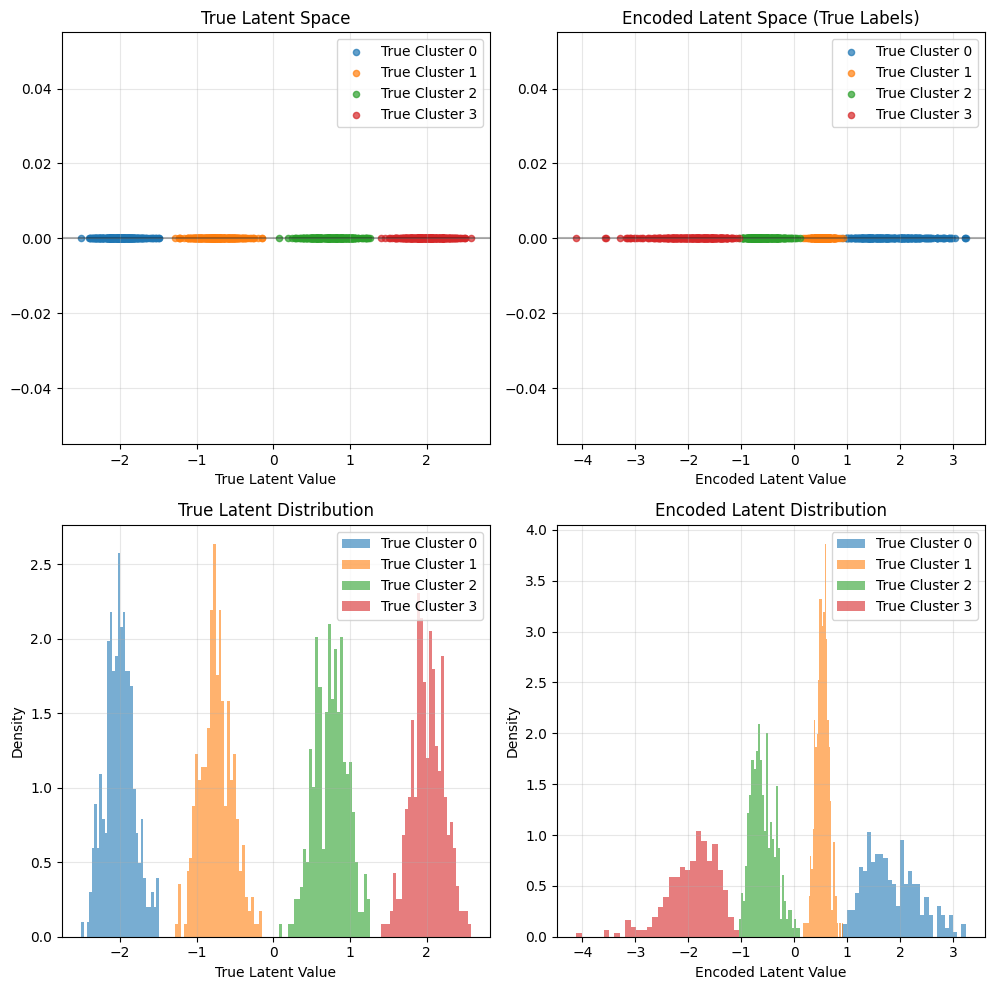

In [8]:
# Visualize results
plt.figure(figsize=(15, 10))

# Plot 1: True vs Predicted latent space
plt.subplot(2, 3, 1)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(Z_true[mask, 0], np.zeros_like(Z_true[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'True Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('True Latent Value')
plt.ylabel('')
plt.title('True Latent Space')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Encoded latent space colored by true labels
plt.subplot(2, 3, 2)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(enc_mu[mask, 0], np.zeros_like(enc_mu[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'True Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Encoded Latent Value')
plt.ylabel('')
plt.title('Encoded Latent Space (True Labels)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Histogram comparison - True latent
plt.subplot(2, 3, 4)
for i in range(n_clusters):
    mask = y == i
    plt.hist(Z_true[mask, 0], bins=30, alpha=0.6, label=f'True Cluster {i}', density=True)
plt.xlabel('True Latent Value')
plt.ylabel('Density')
plt.title('True Latent Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Histogram comparison - Encoded latent
plt.subplot(2, 3, 5)
for i in range(n_clusters):
    mask = y == i
    plt.hist(enc_mu[mask, 0], bins=30, alpha=0.6, label=f'True Cluster {i}', density=True)
plt.xlabel('Encoded Latent Value')
plt.ylabel('Density')
plt.title('Encoded Latent Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
from scipy.stats import pearsonr
r, p = pearsonr(enc_mu.reshape(-1), Z_true.reshape(-1))   # r is Pearson ρ estimate, p is two-sided p-value
abs_r = abs(r)
print(abs_r)

0.9835334657665833


In [10]:
from sklearn.mixture import GaussianMixture

Z_latent = enc_mu.reshape(-1,1)
model_gmm = GaussianMixture(n_components=4, covariance_type="full", random_state=0).fit(Z_latent)

resp_gmm = model_gmm.predict_proba(Z_latent)
labels_gmm = model_gmm.predict(Z_latent)

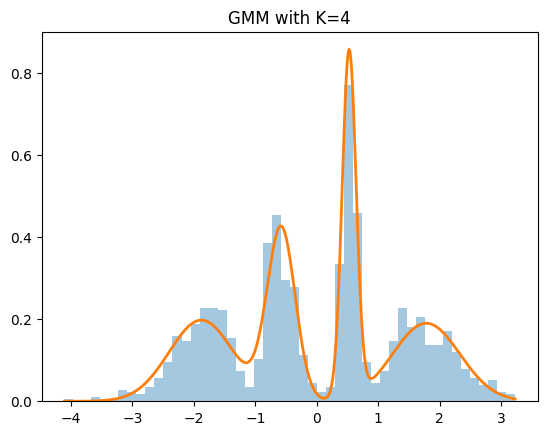

In [11]:
import matplotlib.pyplot as plt
xs = np.linspace(Z_latent.min(), Z_latent.max(), 500)[:, None]
logprob = model_gmm.score_samples(xs)                  # log p(x)
pdf = np.exp(logprob)

plt.figure()
plt.hist(Z_latent, bins=50, density=True, alpha=0.4)
plt.plot(xs, pdf, linewidth=2)
plt.title(f"GMM with K={model_gmm.n_components}")
plt.show()

In [12]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score(y, labels_gmm, average_method="arithmetic")
ari = adjusted_rand_score(y, labels_gmm)

print("NMI:", nmi)
print("ARI:", ari)

NMI: 0.9858619030961138
ARI: 0.9911261096620864


In [34]:
if frames:
    imageio.mimsave(
        "latent_hist_evolution_ae.mp4",
        frames,
        fps=5,
        macro_block_size=None,
    )
    print("Saved video to latent_hist_evolution.mp4")
else:
    print("No frames collected; check your epoch condition.")

Saved video to latent_hist_evolution.mp4
